In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from skmultilearn.model_selection import iterative_train_test_split
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image
import seaborn as sns

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights
from torchvision.transforms import RandomHorizontalFlip, RandomRotation


In [2]:
dataset_directory = "../Dataset Generation/dataset"

images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            # Testing with only first image as these are best quality
            first_image = data['images'][0]
            images.append(os.path.join(dataset_directory, recipe_folder, first_image))
            labels.append(allergens)

            """"
            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)
            """

In [3]:
x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

In [4]:
zeros_per_label = np.sum(y == 0, axis=0).tolist()
ones_per_label = np.sum(y == 1, axis=0).tolist()

print("Number of 0s for each label:")
print(zeros_per_label)
print("Number of 1s for each label:")
print(ones_per_label)

Number of 0s for each label:
[22680, 34421, 26329, 28608, 34837, 33485, 14543, 33087, 33953, 33421, 34926, 36203, 36203, 35480]
Number of 1s for each label:
[13523, 1782, 9874, 7595, 1366, 2718, 21660, 3116, 2250, 2782, 1277, 0, 0, 723]


In [5]:
x_train, y_train, x_temp, y_temp = iterative_train_test_split(x, y, test_size=0.3) # http://scikit.ml/stratification.html

In [6]:
x_test, y_test, x_val, y_val = iterative_train_test_split(x_temp, y_temp, test_size=0.5)

In [7]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

(25342, 1) (25342, 14) (5430, 1) (5430, 14) (5431, 1) (5431, 14)


In [8]:
x_train, y_train, x_test, y_test, x_val, y_val

(array([['../Dataset Generation/dataset/mozzarella,_tomato_and_basil_salad/images/image_1.jpg'],
        ['../Dataset Generation/dataset/01820/images/img01820.jpg'],
        ['../Dataset Generation/dataset/26923/images/img26923.jpg'],
        ...,
        ['../Dataset Generation/dataset/13695/images/img13695.jpg'],
        ['../Dataset Generation/dataset/more_please!_ground_turkey_casserole/images/image_1.jpg'],
        ['../Dataset Generation/dataset/01637/images/img01637.jpg']],
       dtype='<U115'),
 array([[0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([['../Dataset Generation/dataset/14576/images/img14576.jpg'],
        ['../Dataset Generation/dataset/00680/images/img00680.jpg'],
        ['../Dataset Generation/dataset/20303/images/img20303.jpg'],
        ...,
        ['../Dataset Generation/dataset/02745/images/img02

In [9]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images 
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

In [11]:
train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
val_dataset = FoodAllergenDataset(x_val, y_val, transform=transform)
test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

In [12]:
# Hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 50

In [13]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [15]:
"""
# Sample CNN model from pytorch

class Net(nn.Module):
    def __init__(self, num_labels=14):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_labels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
"""

'\n# Sample CNN model from pytorch\n\nclass Net(nn.Module):\n    def __init__(self, num_labels=14):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 29 * 29, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, num_labels)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = x.view(-1, 16 * 29 * 29)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\n\nnet = Net()\n'

In [16]:
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, 14)

In [17]:
#model = Net().to(device)
model = resnet.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# Define loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    # Return average training loss
    return total_loss / len(dataloader)


In [20]:
def val_loop(dataloader, model, loss_fn):
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            loss = loss_fn(prediction, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader)
    print(f"Validation loss: {avg_val_loss:.7f}")
    # Return average validation loss
    return avg_val_loss


In [21]:
# Store losses to be graphed
training_losses = []
validation_losses = []

for epoch in range (epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, model, loss_fn)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)
print(f"Training Complete")

Epoch 1/50
loss: 0.6838122 [    0/25342]
loss: 0.6817333 [ 6400/25342]
loss: 0.6828788 [12800/25342]
loss: 0.6776595 [19200/25342]
Epoch 2/50
loss: 0.6766713 [    0/25342]
loss: 0.6766280 [ 6400/25342]
loss: 0.6745409 [12800/25342]
loss: 0.6699798 [19200/25342]
Epoch 3/50
loss: 0.6676247 [    0/25342]
loss: 0.6670029 [ 6400/25342]
loss: 0.6631887 [12800/25342]
loss: 0.6628544 [19200/25342]
Epoch 4/50
loss: 0.6628643 [    0/25342]
loss: 0.6555209 [ 6400/25342]
loss: 0.6560982 [12800/25342]
loss: 0.6508411 [19200/25342]
Epoch 5/50
loss: 0.6498262 [    0/25342]
loss: 0.6483178 [ 6400/25342]
loss: 0.6481032 [12800/25342]
loss: 0.6470273 [19200/25342]
Epoch 6/50
loss: 0.6433257 [    0/25342]
loss: 0.6383058 [ 6400/25342]
loss: 0.6421497 [12800/25342]
loss: 0.6389414 [19200/25342]
Epoch 7/50
loss: 0.6361570 [    0/25342]
loss: 0.6322121 [ 6400/25342]
loss: 0.6373805 [12800/25342]
loss: 0.6312104 [19200/25342]
Epoch 8/50
loss: 0.6241862 [    0/25342]
loss: 0.6240115 [ 6400/25342]
loss: 0.6246

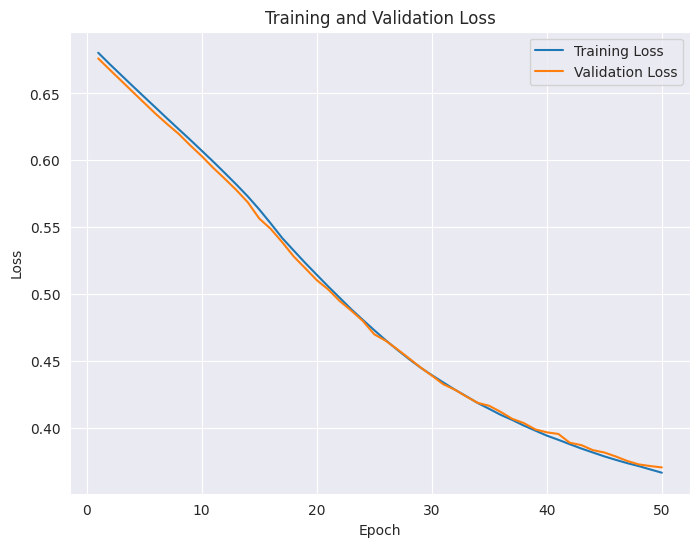

In [22]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
correct = 0
total = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        predicted_probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (predicted_probs > 0.5).float()  # Apply threshold to get binary predictions

        # Count total labels
        total += labels.numel()  # Total number of labels in the dataset. i.e. 14 labels per image.

        # Count correctly predicted labels
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test dataset: {accuracy:.2f} %')


Accuracy of the network on the test dataset: 87.84 %


In [24]:
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Convert logits to probabilities
        probs = torch.sigmoid(outputs)

        # Binary predictions at threshold=0.5
        preds = (probs > 0.5).long()

        all_predictions.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

# Concatenate across batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Generate the multi-label confusion matrix for all labels at once
matrices = multilabel_confusion_matrix(all_targets, all_predictions)


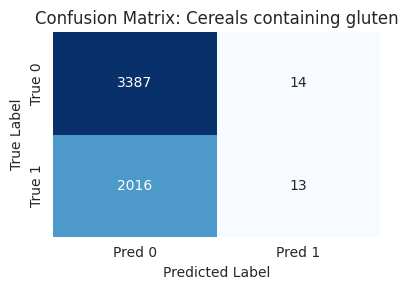

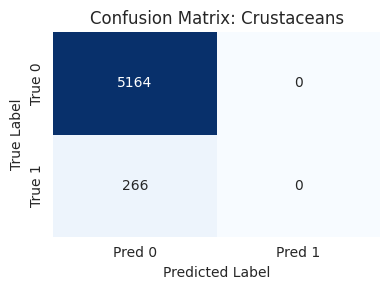

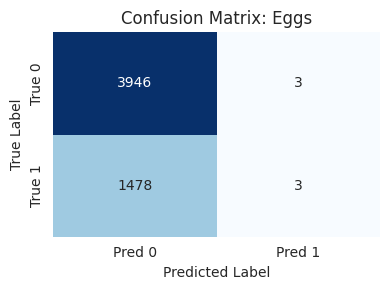

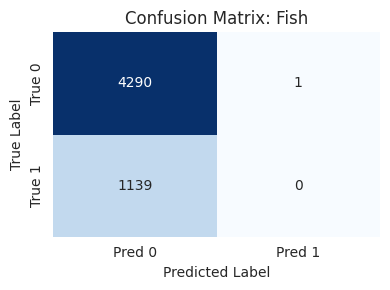

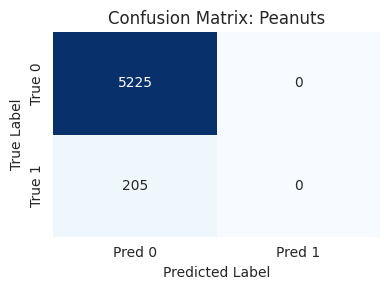

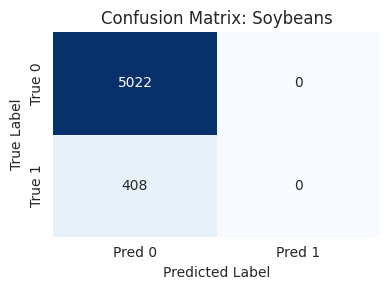

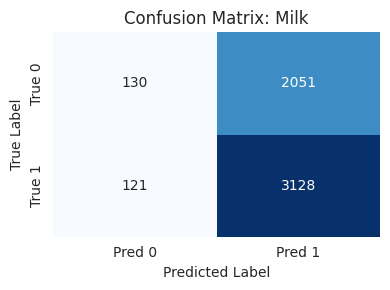

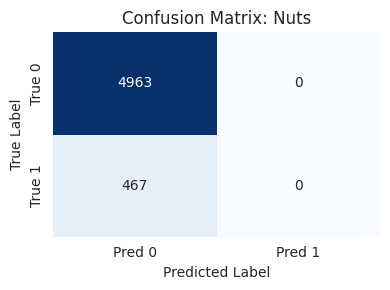

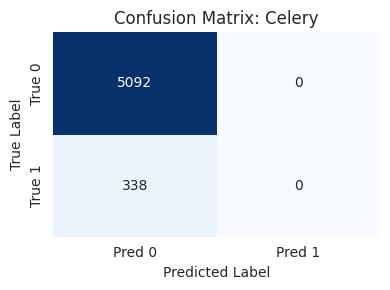

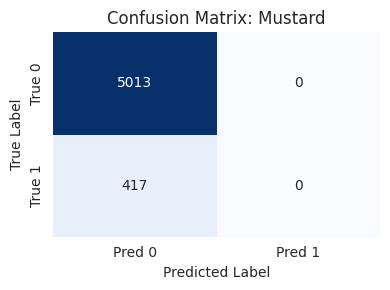

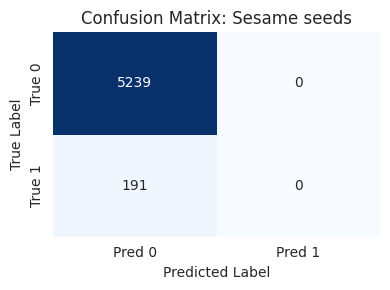

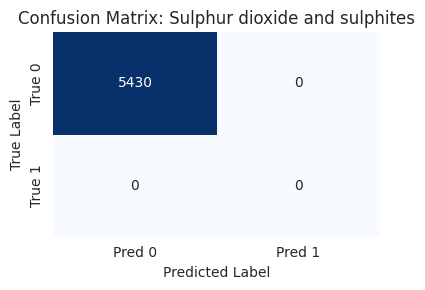

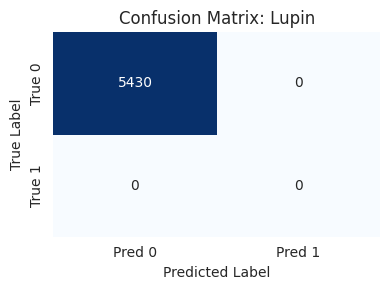

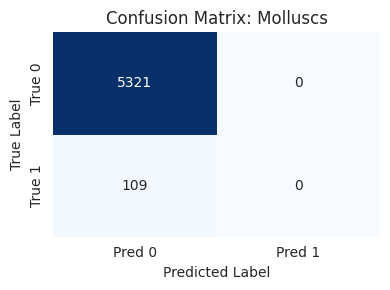

In [25]:
ALLERGENS = [
    "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
    "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
    "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
]

# Plot matrices on seaborn

for i, matrix in enumerate(matrices):
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"]
    )
    plt.title(f"Confusion Matrix: {ALLERGENS[i]}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
